In [1]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from rasp_models.dominantpeak import get_dompeak_model
from tracr.haiku_to_pytorch import haiku_to_pytorch, apply

from datasets.dataloaders import makeDomPeakDataLoader
from torchinfo import summary

In [2]:
loader = makeDomPeakDataLoader()

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = get_dompeak_model()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [4]:
def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if torch.isnan(sum(sum(sum(model_output)))):
        print(inputs)
        print(outputs)
        print(model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {
        "logits": model_output
    }

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          87,683
│    │    └─TracrMLP: 3-2                170,397
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          87,683
│    │    └─TracrMLP: 3-4                170,397
│    └─TracrBlock: 2-3                   --
│    │    └─TracrAttention: 3-5          87,683
│    │    └─TracrMLP: 3-6                170,397
│    └─TracrBlock: 2-4                   --
│    │    └─TracrAttention: 3-7          87,683
│    │    └─TracrMLP: 3-8                170,397
│    └─TracrBlock: 2-5                   --
│    │    └─TracrAttention: 3-9          87,683
│    │    └─TracrMLP: 3-10               170,397
│    └─TracrBlock: 2-6                   --
│    │    └─TracrAttention: 3-11         87,683
│    │    └─TracrMLP: 3-12               170,397
│    └─TracrBlock

In [6]:
print(torch_model)

TracrTransformer(
  (layers): ModuleList(
    (0-7): 8 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=227, out_features=96, bias=True)
        (key): Linear(in_features=227, out_features=96, bias=True)
        (value): Linear(in_features=227, out_features=96, bias=True)
        (output): Linear(in_features=96, out_features=227, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=227, out_features=374, bias=True)
        (linear2): Linear(in_features=374, out_features=227, bias=True)
      )
    )
  )
)


In [7]:
all_llcs = []

for _ in range(100):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-6, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,
        num_draws=100,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    llc_avg = sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means'])
    all_llcs.append(llc_avg)
    print(round(llc_avg, 2))

overall_avg_llc = sum(all_llcs) / len(all_llcs)
print(f"\nOverall average LLC across 3 runs: {round(overall_avg_llc, 2)}")

/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/swey/miniconda3/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the s

2.95


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


3.34


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


2.89


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


2.51


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


0.92


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


2.57


Chain 9: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


4.13


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


2.44


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


3.66


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


2.55


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


4.27


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


3.49


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


2.01


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


2.43


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


3.58


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


2.37


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


1.81


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


2.4


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


4.04


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


2.17


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


3.66


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


3.16


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


3.29


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


2.17


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


2.86


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


1.3


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


2.83


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


4.2


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


2.93


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


3.09


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


2.36


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


1.57


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


3.47


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


2.3


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


2.17


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


2.68


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


3.98


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


2.98


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


2.56


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


2.16


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


2.45


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]


2.81


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


2.14


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


3.23


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


2.61


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


1.72


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


3.34


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


3.0


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


2.0


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.65it/s]


1.81


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]


2.02


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


1.81


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


2.42


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


2.69


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


2.58


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


3.19


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


1.94


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


1.98


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


2.42


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


1.91


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


5.74


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.35it/s]


5.18


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


3.88


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


1.25


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


0.63


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


2.26


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


2.37


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


2.94


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


2.75


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


3.36


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


2.18


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


2.3


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 14.20it/s]


3.12


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


4.32


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


1.94


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


2.61


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


2.94


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


3.35


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


1.61


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


1.71


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


2.96


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


3.02


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


2.39


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


1.82


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


1.67


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


2.85


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


1.42


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


1.86


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.96it/s]


4.59


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


2.79


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


2.0


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


2.08


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


3.23


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


2.58


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


3.21


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


1.71


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


1.92


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


1.11


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


1.45


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]

3.27

Overall average LLC across 3 runs: 2.65


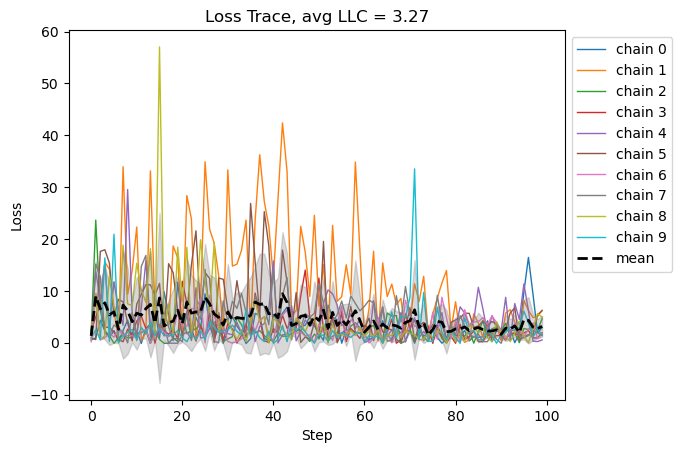

<Figure size 1200x900 with 0 Axes>

In [8]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)